In [7]:
# -*- coding: utf-8 -*-
"""
Created on June 2025
Updated September 2025

@author: parisa.rahdan

This script uses solar production data from the plant (https://github.com/Parisra/UEF/tree/main/data/inverter_monthly_datafiles) and 
meter data (https://github.com/martavp/UEF/tree/main/data/meter_data) from the buildings to visulaize 
electricity demand vs. solar production during the year, and also calculate and visualise solar self-consumption (the share
of produced solar energy consumed onsite by the buildings).

NOTE: All dates in this script are in CET/CEST

The solar plant is located in the roof of buildings 1481 and 1483. 
See:  https://doi.org/10.1002/pip.70009 for more information about the installation
The cleaned meter data shows how much electricity was exported from buildings 1481 and 1483 to the grid (from the solar plant), and
how much electricity was imported, at each 15 min. interval
"""

import pandas as pd 

tz = 'CET' 
start_date = '2024-09-01 00:00:00' 
end_date = '2025-10-01 23:55:00'
time_index = pd.date_range(start=start_date, 
                               end=end_date, 
                               freq
                           ='5min',  
                               tz=tz
                               )

meter_data = pd.read_csv("clean_meter_data_202409to202509.csv", index_col=1)

meter_data= meter_data.set_index((pd.to_datetime(meter_data.index)).tz_localize(tz=tz, ambiguous="NaT", nonexistent="NaT")).drop(labels=['Unnamed: 0'], axis=1)
meter_data=meter_data.rename(columns={"571313115104062185": "1483_consumption", "571313115104062192": "1483_consumption_"})

meter_data

,1481_from_grid,1481_to_grid,1483_from_grid,1483_to_grid,1483_consumption,1483_consumption_
Timestamp,,,,,,
2024-09-13 00:00:00+02:00,5.28,0.0,1.44,0.0,0.369,0.800
2024-09-13 00:15:00+02:00,5.04,0.0,1.38,0.0,0.287,0.793
2024-09-13 00:30:00+02:00,4.92,0.0,1.38,0.0,0.347,0.788
2024-09-13 00:45:00+02:00,5.64,0.0,1.38,0.0,0.342,0.797
2024-09-13 01:00:00+02:00,4.68,0.0,1.38,0.0,0.376,0.821
...,...,...,...,...,...,...
2025-09-12 22:45:00+02:00,3.60,0.0,1.44,0.0,0.235,0.785
2025-09-12 23:00:00+02:00,3.60,0.0,1.44,0.0,0.231,0.778
2025-09-12 23:15:00+02:00,3.84,0.0,1.38,0.0,0.231,0.788


In [ ]:
# -*- coding: utf-8 -*-

"""
This script retrieves raw data files from the inverters datalogger,
and the solar radiation from the closest DMI weather station, 
creates a data file named 'clean_data.csv' and 
stores it in the folder 'resources'.
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import date, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def retrieve_inverter(data_path, clean_data, inverter, start_date, end_date, tz): 

    """
    Retrieve inverters data (collected trough solar fussion)
    """

    #index to read the datafiles, one datafile per month, 
    time_index_month = pd.date_range(start=start_date, 
                                     end=end_date, 
                                     freq='M',  
                                     tz=tz)
    
    for m in time_index_month:
    
        fn='Inverter_{}_{}_{}.xlsx'.format(inverter,m.year, str(m.month).zfill(2))
        #print('retrieving ' + fn)
        input_data = pd.read_excel((data_path + fn),
                                   sheet_name="5 minutes", 
                                   index_col=3, 
                                   header=0, 
                                   skiprows=3,
                                   engine='openpyxl').squeeze("columns")
    
        input_data.index = pd.to_datetime(input_data.index, format="mixed").tz_localize(tz=tz)

        clean_data.loc[input_data.index,['Inverter {} Total input power (kW)'.format(inverter)]] = input_data['Total input power(kW)']
        for pv_string in [1,2,3,4,5,6,7,8]:
            clean_data.loc[input_data.index,['Inverter {} PV{} input current(A)'.format(inverter,pv_string)]] = input_data['PV{} input current(A)'.format(pv_string)]
            clean_data.loc[input_data.index,['Inverter {} PV{} input voltage(V)'.format(inverter,pv_string)]] = input_data['PV{} input voltage(V)'.format(pv_string)]


    return clean_data


# Create empty dataframe to be populated
tz = 'CET' 
start_date = '2024-09-01 00:00:00' # '2025-05-27 00:00:00' 
end_date = '2025-10-01 23:55:00'
time_index = pd.date_range(start=start_date, 
                               end=end_date, 
                               freq='5min',  
                               tz=tz)
clean_data=pd.DataFrame(index=time_index)   


#retrieve data from inverters, dateindex in CET/CEST (indicated by DST)
data_path='https://github.com/martavp/UEF/raw/refs/heads/main/data/inverter_monthly_datafiles/'
for inverter in [1,2]:
    clean_data = retrieve_inverter(data_path, 
                                   clean_data, 
                                   inverter=inverter,
                                   start_date = start_date, 
                                   end_date = end_date, 
                                   tz='CET')






In [9]:
"""
Inverter output is in KW for every 5 minutes -> conversion to KWh (*5/60) , then sum for every 15 minutes to match 
the time resolution of the meter data
"""

data_production= (clean_data.groupby([pd.Grouper(freq='15min')]).sum()).filter(like='Total input')/12 ##KW to kWh
data_production = data_production['2024-09-13 00:00:00+00:00':'2025-09-12  23:45:00+00:00']
data_production=data_production.set_index(meter_data.index)
data_production= data_production.rename(columns={
                                          "Inverter 1 Total input power (kW)": "Inverter 1 production (kWh)",
                                          "Inverter 2 Total input power (kW)": "Inverter 2 production (kWh)"})
data_production

,Inverter 1 production (kWh),Inverter 2 production (kWh)
Timestamp,,
2024-09-13 00:00:00+02:00,0.0,0.0
2024-09-13 00:15:00+02:00,0.0,0.0
2024-09-13 00:30:00+02:00,0.0,0.0
2024-09-13 00:45:00+02:00,0.0,0.0
2024-09-13 01:00:00+02:00,0.0,0.0
...,...,...
2025-09-12 22:45:00+02:00,0.0,0.0
2025-09-12 23:00:00+02:00,0.0,0.0
2025-09-12 23:15:00+02:00,0.0,0.0


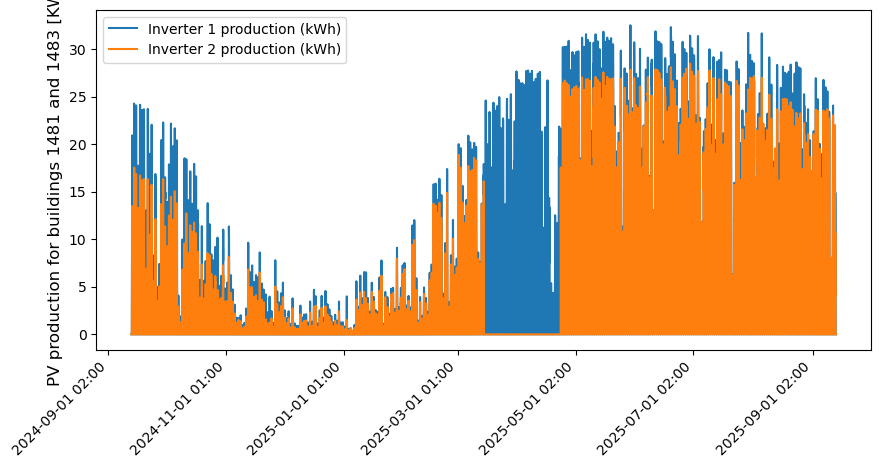

In [10]:
"""
Comparison of the production from the installations
Note that the 2nd installations was disconnected for a preiod of one month in summer 2025 due to technical isuues.
Size of each plant is ≈49 KW. Plot shows hourly production in KWh.
"""
import matplotlib.dates as mdates

fig, ax= plt.subplots(figsize=(10, 5))

to_plot = data_production.groupby([pd.Grouper(freq='1h')]).sum()
ax.plot(to_plot.index.tz_convert(None) , to_plot.values, label=to_plot.columns)

# format x-axis with timezone-aware formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M", tz=to_plot.index.tz))
ax.set_ylabel('PV production for buildings 1481 and 1483 [KWh]', fontsize=12)

ax.legend()
fig.autofmt_xdate(rotation=45)

In [11]:
"""
To calculate self-consumption:
   electrcity demand + electricity exported to grid = Solar production + electricity imported from grid 
Self consumption is the share of solar production that was used in the building, 
so it can be calculated by deducting any electricity exports:
   self-consumption share = (Solar PV production - electicity exports) / solar PV production
"""
meter_data['1481_self_consumption'] = (data_production['Inverter 1 production (kWh)']
                             -meter_data['1481_to_grid'])/data_production['Inverter 1 production (kWh)']

meter_data['1483_self_consumption'] = (data_production['Inverter 2 production (kWh)']
                             -meter_data['1483_to_grid'])/data_production['Inverter 2 production (kWh)']

""" 
Calculate electricity demand for the two buildings from meter data
"""

meter_data['1481_demand'] = (meter_data['1481_from_grid']+data_production['Inverter 1 production (kWh)']
                             -meter_data['1481_to_grid'])

meter_data['1483_demand'] = (meter_data['1483_from_grid']+meter_data['1483_consumption']+meter_data['1483_consumption_']
                             +data_production['Inverter 2 production (kWh)']
                             -meter_data['1483_to_grid'])


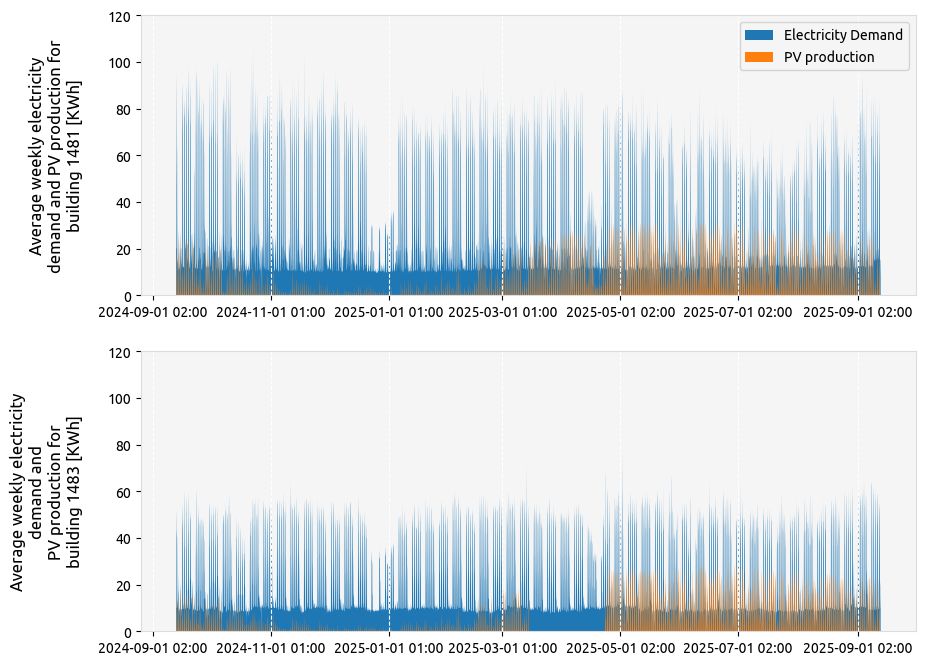

In [12]:
"""
Electricity demand and solar PV production during the year for the 2 buildings
"""

import numpy as np

plt.rc('font',family='Ubuntu')
plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"white" , "grid.linestyle":"dashed"})


fig, axs = plt.subplots(2,1,figsize=(10,8))
find_empty= data_production.groupby([data_production.index.year, data_production.index.month, data_production.index.day]).sum()

for k, to_plot in enumerate(['1481_demand','1483_demand']) :
 axs[k].grid(axis='y')
 df_demand = pd.DataFrame(meter_data.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).sum()) ##hourly demand KWh
 axs[k].fill_between(df_demand.index.tz_convert(None), df_demand[to_plot].values,   
                         label='Electricity Demand')

 string=str(k+1)+' production' 
 column_=[i for i in data_production.columns if string in i][0]
 nan_idx = data_production.index[data_production[column_].isna()].tolist()
 data_= data_production[column_].drop(labels=nan_idx)
 data_ = pd.DataFrame(data_.groupby(
                     pd.Grouper(freq='1H')).sum()) 

 axs[k].fill_between(data_.index.tz_convert(None), data_.sum(axis=1).values, 
                         label='PV production')

 
#meter_data.index.tz_convert(None), meter_data['1481_demand'].values
axs[0].set_ylabel('Average weekly electricity\ndemand and PV production for\nbuilding 1481 [KWh]\n', fontsize=12)
axs[1].set_ylabel('Average weekly electricity\ndemand and\nPV production for\nbuilding 1483 [KWh]\n', fontsize=12)
axs[0].set_ylim([0,120])
axs[1].set_ylim([0,120])

axs[0].legend()

for ax in axs.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M", tz=meter_data.index.tz))


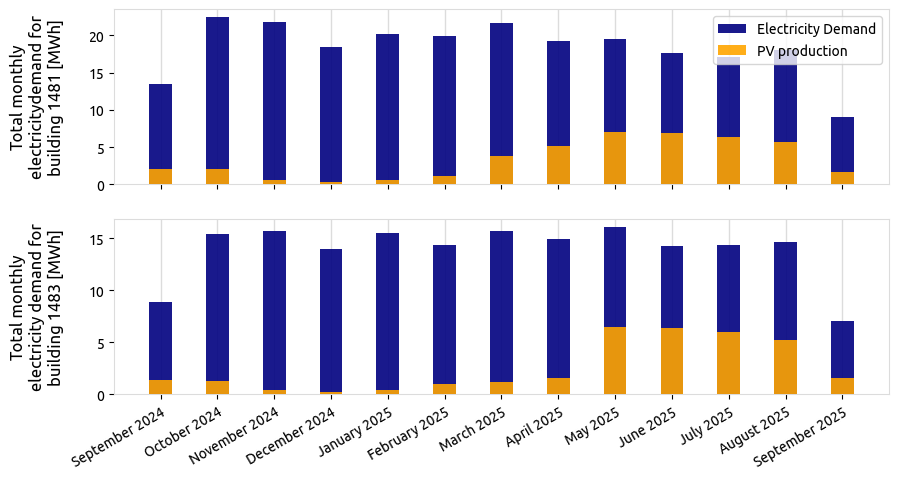

In [13]:
"""
Comparing monthly electricity demand and PV production
"""
import matplotlib.patches as mpatches

plt.rc('axes',edgecolor='gainsboro')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({"axes.grid" : True, "grid.color" :"gainsboro" , "grid.linestyle":"dashed"})


fig, ax = plt.subplots(2,1, figsize=(10,5), sharex= True)


for k, to_plot in enumerate(['1481_demand','1483_demand']) :
 ax[k].grid(axis='y')
 df_demand = pd.DataFrame(meter_data.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).sum()) ##hourly demand KWh

 to_plot_= df_demand.groupby([df_demand.index.year, df_demand.index.month 
                             ]).sum()/1e3 ##MWh  
 ax[k].bar(np.arange(len(to_plot_.index)), to_plot_[to_plot].values, 0.4 ,   
                          color='navy',label='Electricity Demand',alpha=0.9,lw=2,zorder =3)
    
 string=str(k+1)+' production' 
 column_=[i for i in data_production.columns if string in i][0]
 to_plot_= data_production.groupby([data_production.index.year, data_production.index.month 
                             ]).sum()[column_]/1e3 ##MWh  
 ax[k].bar(np.arange(len(to_plot_.index)), to_plot_.values, 0.4 ,   
                          color='orange',label='PV production',alpha=0.9,lw=2,zorder =3)


    
 #if k==0 : ax[k].legend()    
 ticklabels = pd.date_range(start=clean_data.index[0], 
                           end=data_production.index[-1], 
                           freq="MS").strftime("%B %Y").tolist()
    
 ax[k].set_xticks(np.arange(len(to_plot_.index)))    
 ax[k].set_xticklabels(ticklabels,
                        fontsize=10, rotation=30,ha='right', rotation_mode='anchor')
 ax[k].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
 ax[k].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
 #ax[k].set_xlim([index[0],index[-1]])  

ax[0].set_ylabel('Total monthly\nelectricitydemand for\nbuilding 1481 [MWh]\n', fontsize=12)
ax[1].set_ylabel('Total monthly\nelectricity demand for\nbuilding 1483 [MWh]\n', fontsize=12)
#ax[0].set_ylim([0,180])
#ax[1].set_ylim([0,100])

ax[0].legend()


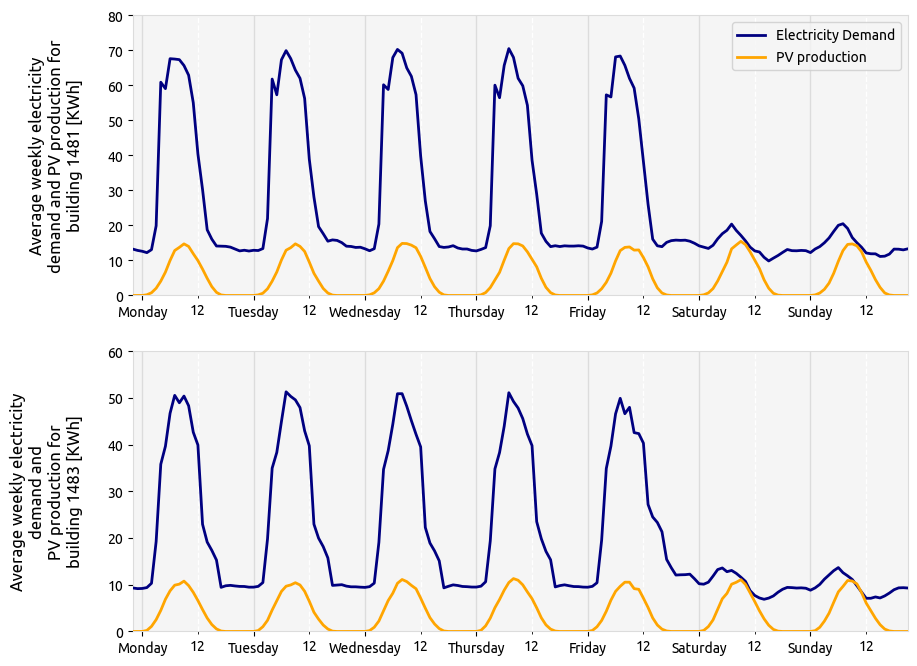

In [14]:
"""
Avergae weekly profle of the electricity demand and PV production
"""

import numpy as np

plt.rc('font',family='Ubuntu')
plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"white" , "grid.linestyle":"dashed"})


fig, ax = plt.subplots(2,1,figsize=(10,8))
find_empty= data_production.groupby([data_production.index.year, data_production.index.month, data_production.index.day]).sum()

for k, to_plot in enumerate(['1481_demand','1483_demand']) :
 ax[k].grid(axis='y')
 df_demand = pd.DataFrame(meter_data.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).sum()) ##hourly demand KWh
 df_demand['weekday']=(df_demand.index.weekday)
 df_demand['hour']=(df_demand.index.hour)
 monday = df_demand[df_demand['weekday']==0].index[0]   
 index =df_demand[monday:monday+timedelta(hours=167)].index ##datetime strarting from a monday at midnight


 ax[k].plot(index, df_demand.groupby([df_demand['weekday'],  
                              df_demand['hour']]).mean()[to_plot].values,   
                          color='navy',label='Electricity Demand',lw=2,zorder =3)

 string=str(k+1)+' production' 
 column_=[i for i in data_production.columns if string in i][0]
 nan_idx = data_production.index[data_production[column_].isna()].tolist()
 data_= data_production[column_].drop(labels=nan_idx)
 data_ = pd.DataFrame(data_.groupby(
                     pd.Grouper(freq='1H')).sum())
    
 data_['weekday']=(data_.index.weekday)
 data_['hour']=(data_.index.hour)
 monday = data_[data_['weekday']==0].index[0]   
 index =data_[monday:monday+timedelta(hours=167)].index ##datetime strarting from a monday at midnight
    
 ax[k].plot(index, data_.groupby([data_['weekday'],  
                              data_['hour']]).mean().sum(axis=1).values, 
                          color='orange',label='PV production',lw=2,zorder =3)

 ax[k].xaxis.set_major_locator(mdates.DayLocator())
 ax[k].xaxis.set_minor_locator(mdates.HourLocator(byhour = [12]))
 ax[k].xaxis.set_minor_locator(mdates.HourLocator(byhour = [12]))
 ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%A'))
 ax[k].xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
 ax[k].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
 ax[k].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
 ax[k].set_xlim([index[0],index[-1]])  

ax[0].set_ylabel('Average weekly electricity\ndemand and PV production for\nbuilding 1481 [KWh]\n', fontsize=12)
ax[1].set_ylabel('Average weekly electricity\ndemand and\nPV production for\nbuilding 1483 [KWh]\n', fontsize=12)
ax[0].set_ylim([0,80])
ax[1].set_ylim([0,60])

ax[0].legend()




1 production
2 production


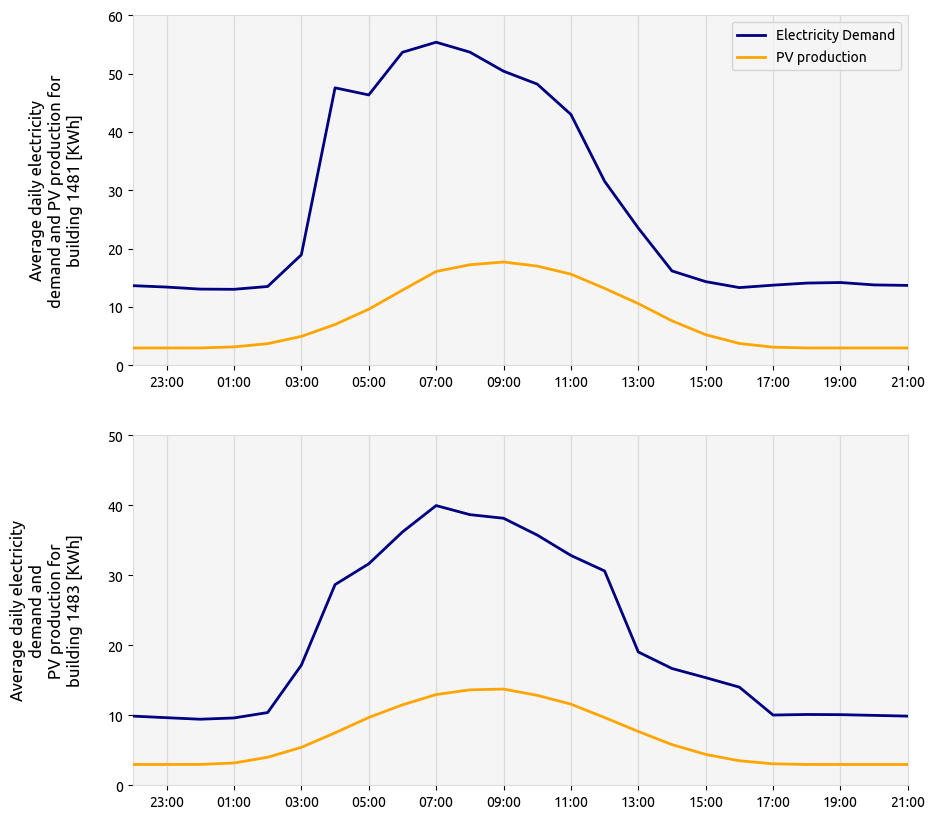

In [16]:
"""
Average daily profle of the electricity demand and PV production
"""
import matplotlib.ticker as ticker
import numpy as np

plt.rc('font',family='Ubuntu')
plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"white" , "grid.linestyle":"dashed"})


fig, ax = plt.subplots(2,1,figsize=(10,10))


for k, to_plot in enumerate(['1481_demand','1483_demand']) :
 ax[k].grid(axis='y')
 df_demand = pd.DataFrame(meter_data.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).sum()) ##hourly demand KWh
 df_demand['weekday']=(df_demand.index.weekday)
 df_demand['hour']=(df_demand.index.hour)
 index =df_demand[24:24+24].index ##datetime strarting from a monday at midnight

 ax[k].plot(index, df_demand.groupby([df_demand['hour']
                                     ]).mean()[to_plot].values,   
                          color='navy',label='Electricity Demand',lw=2,zorder =3)

 string=str(k+1)+' production'
 print(string)
 data_ = pd.DataFrame(data_production.filter(like=string).groupby(
                     pd.Grouper(freq='1H')).sum())
 data_['weekday']=(data_.index.weekday)
 data_['hour']=(data_.index.hour)

 ax[k].plot(index, data_.groupby([data_['hour']]
                                          ).mean().sum(axis=1).values,   
                          color='orange',label='PV production',lw=2,zorder =3)

 #ax[k].xaxis.set_major_locator(mdates.DayLocator())
 #ax[k].xaxis.set_major_locator(mdates.HourLocator(byhour = 2))
 ax[k].xaxis.set_major_locator(mdates.HourLocator(interval=2))
 #ax[k].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
 #ax[k].xaxis.set_major_formatter(mdates.DateFormatter("%H"))
 ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
 #ax[k].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 240]))
 #ax[k].xaxis.set_major_locator(ticker.MultipleLocator(2)) 
 ax[k].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
 ax[k].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
 ax[k].set_xlim([index[0],index[-1]])  
    
ax[0].set_ylabel('Average daily electricity\ndemand and PV production for\nbuilding 1481 [KWh]\n', fontsize=12)
ax[1].set_ylabel('Average daily electricity\ndemand and\nPV production for\nbuilding 1483 [KWh]\n', fontsize=12)
ax[0].set_ylim([0,60])
ax[1].set_ylim([0,50])

ax[0].legend()



0
3740


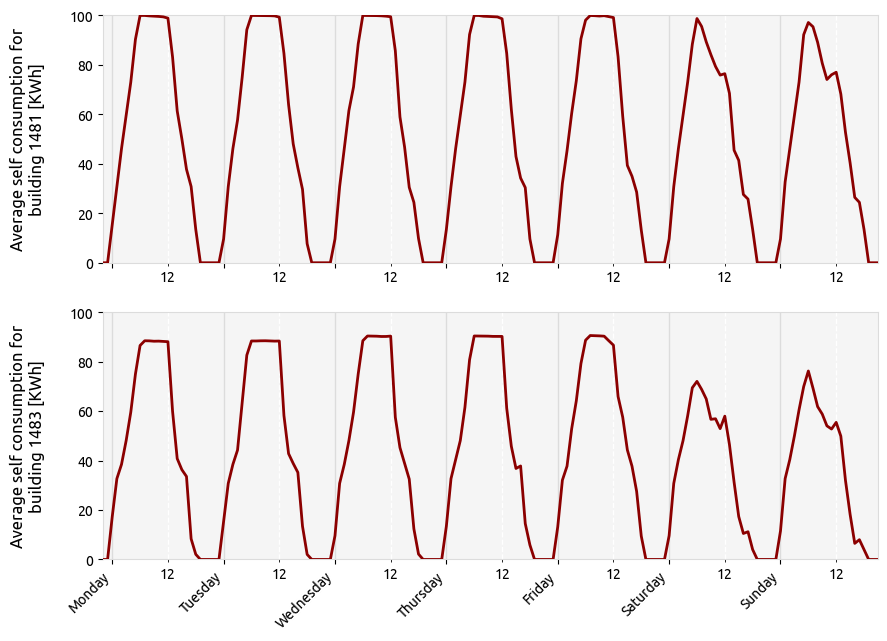

In [17]:
"""
Average weekly pattern of self-consumption from PV production
"""

import numpy as np

plt.rc('font',family='Ubuntu')
plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"white" , "grid.linestyle":"dashed"})


fig, ax = plt.subplots(2,1,figsize=(10,8))

find_empty= data_production.groupby([data_production.index.year, data_production.index.month, data_production.index.day]).sum()

for k, to_plot in enumerate(['1481_self_consumption','1483_self_consumption']) :
 ax[k].grid(axis='y')

 string=str(k+1)+' production' 
 column_=[i for i in data_production.columns if string in i][0]
 ## filter out the time period when the solar installation was disconnected   
 to_drop= [i for i in data_production.index if not np.isnan(i.day) and find_empty.loc[ 
    (i.year, i.month, i.day) , column_] ==0
  ]
 print(len(to_drop))   
 data_meter_nozero= meter_data.drop(labels=to_drop)

 df_demand = pd.DataFrame(data_meter_nozero.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).mean()).fillna(0)*100 ##hourly demand KWh
 df_demand['weekday']=(df_demand.index.weekday)
 df_demand['hour']=(df_demand.index.hour)
 monday = df_demand[df_demand['weekday']==0].index[0]   
 index =df_demand[monday:monday+timedelta(hours=167)].index ##datetime strarting from a monday at midnight

 df_demand= df_demand.drop(labels=[i for i in df_demand.index if df_demand.loc[i, to_plot]<0])     

    
 ax[k].plot(index, df_demand.groupby([df_demand['weekday'],  
                              df_demand['hour']]).mean()[to_plot].values ,
                          color='darkred',label='Electricity Demand',lw=2,zorder =3)

 ax[k].xaxis.set_major_locator(mdates.DayLocator())
 ax[k].xaxis.set_minor_locator(mdates.HourLocator(byhour = [12]))
 ax[k].xaxis.set_minor_locator(mdates.HourLocator(byhour = [12]))
 ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%A'))
 ax[k].xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
 ax[k].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
 ax[k].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
 ax[k].set_xlim([index[0],index[-1]])  

ax[0].set_ylabel('Average self consumption for\nbuilding 1481 [KWh]\n', fontsize=12)
ax[1].set_ylabel('Average self consumption for\nbuilding 1483 [KWh]\n', fontsize=12)
ax[0].set_ylim([0,100])
ax[1].set_ylim([0,100])

#ax[0].legend()
fig.autofmt_xdate(rotation=45)



(0.0, 100.0)

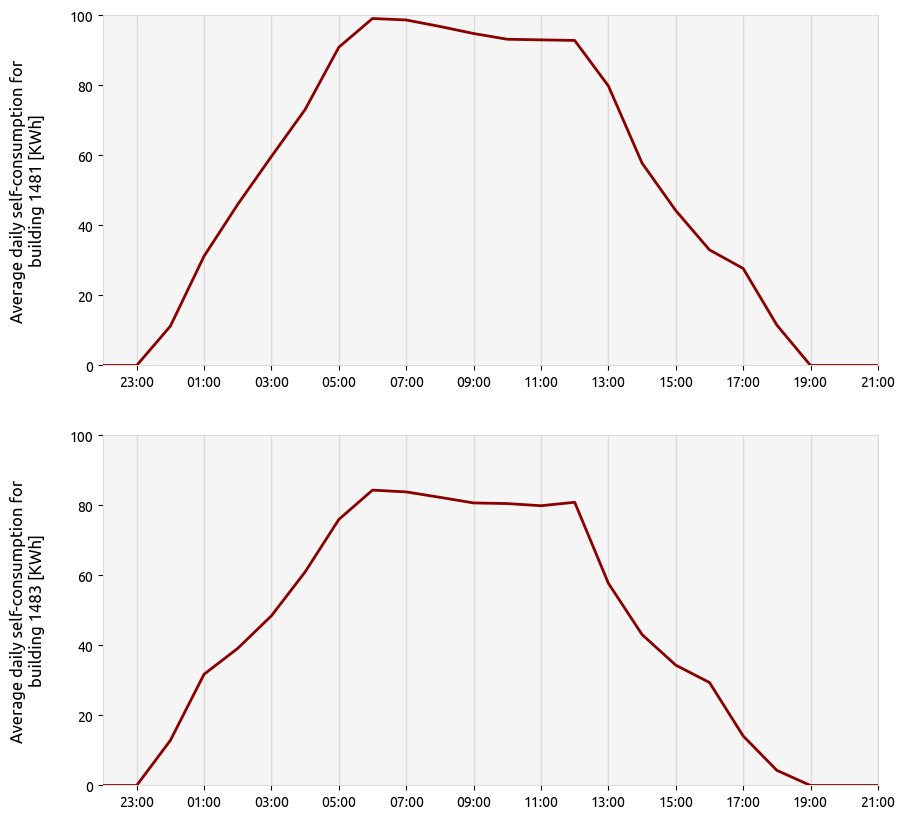

In [18]:
"""
Average daily pattern of self-consumption from PV production
"""
import matplotlib.ticker as ticker
import numpy as np

plt.rc('font',family='Ubuntu')
plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"white" , "grid.linestyle":"dashed"})


fig, ax = plt.subplots(2,1,figsize=(10,10))


for k, to_plot in enumerate(['1481_self_consumption','1483_self_consumption']) :
 ax[k].grid(axis='y')

 string=str(k+1)+' production' 
 column_=[i for i in data_production.columns if string in i][0]
 ## filter out the time period when the solar installation was disconnected   
 to_drop= [i for i in data_production.index if not np.isnan(i.day) and find_empty.loc[ 
    (i.year, i.month, i.day) , column_] ==0]
 #print(len(to_drop))   
 data_meter_nozero= meter_data.drop(labels=to_drop)
    
 df_demand = pd.DataFrame(data_meter_nozero.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).mean()).fillna(0)*100 ##hourly demand KWh
 df_demand['weekday']=(df_demand.index.weekday)
 df_demand['hour']=(df_demand.index.hour)
 monday = df_demand[df_demand['weekday']==0].index[0]   
 index =df_demand[monday:monday+timedelta(hours=23)].index ##datetime strarting from a monday at midnight
 #print(df_demand.groupby([df_demand['hour']]).mean()[to_plot].values)

 df_demand= df_demand.drop(labels=[i for i in df_demand.index if df_demand.loc[i, to_plot]<0])    ## TODO: Why?  

 ax[k].plot(index, df_demand.groupby([df_demand['hour']
                                     ]).mean()[to_plot].values,   
                          color='darkred',label='Electricity Demand',lw=2,zorder =3)

 ax[k].xaxis.set_major_locator(mdates.HourLocator(interval=2))
 #ax[k].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
 #ax[k].xaxis.set_major_formatter(mdates.DateFormatter("%H"))
 ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
 #ax[k].xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 240]))
 #ax[k].xaxis.set_major_locator(ticker.MultipleLocator(2)) 
 ax[k].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
 ax[k].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
 ax[k].set_xlim([index[0],index[-1]])  
    
ax[0].set_ylabel('Average daily self-consumption for\nbuilding 1481 [KWh]\n', fontsize=12)
ax[1].set_ylabel('Average daily self-consumption for\nbuilding 1483 [KWh]\n', fontsize=12)
ax[0].set_ylim([0,100])
ax[1].set_ylim([0,100])

#ax[0].legend()
#fig.autofmt_xdate(rotation=45)



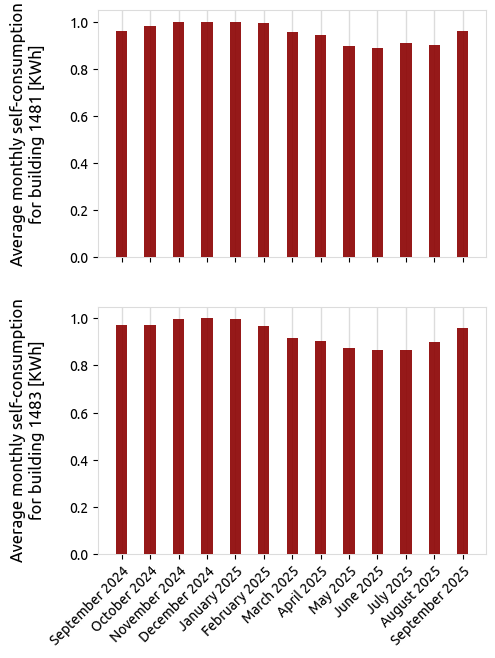

In [19]:
#### Average monthly solar self-consumption share

plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"gainsboro" , "grid.linestyle":"dashed"})


fig, ax = plt.subplots(2,1, figsize=(5,8))


for k, to_plot in enumerate(['1481_self_consumption','1483_self_consumption']) :
 ax[k].grid(axis='y')

 string=str(k+1)+' production' 
 column_=[i for i in data_production.columns if string in i][0]
 ## filter out the time period when the solar installation was disconnected   
 to_drop= [i for i in data_production.index if not np.isnan(i.day) and find_empty.loc[ 
    (i.year, i.month, i.day) , column_] ==0]
 #print(len(to_drop))   
 data_meter_nozero= meter_data.drop(labels=to_drop)
    
 df_demand = pd.DataFrame(data_meter_nozero.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).mean()) ##hourly demand KWh
 df_demand= df_demand.drop(labels=[i for i in df_demand.index if df_demand.loc[i, to_plot]<0])   

 to_plot_= df_demand.groupby([df_demand.index.year, df_demand.index.month 
                             ]).mean()
 ax[k].bar(np.arange(len(to_plot_.index)), to_plot_[to_plot].values, 0.4 ,   
                          color='darkred',label='Self-consumption',alpha=0.9,lw=2,zorder =3)
    
 #print(to_plot_[to_plot])   
 ticklabels = pd.date_range(start=clean_data.index[0], 
                           end=data_production.index[-1], 
                           freq="MS").strftime("%B %Y").tolist()
    
 ax[k].set_xticks(np.arange(len(to_plot_.index)))    
 ax[k].set_xticklabels(ticklabels,
                        fontsize=10, rotation=30,ha='right', rotation_mode='anchor')
 ax[k].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
 ax[k].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
 #ax[k].set_xlim([index[0],index[-1]])  

ax[0].set_ylabel('Average monthly self-consumption\nfor building 1481 [KWh]\n', fontsize=12)
ax[1].set_ylabel('Average monthly self-consumption\nfor building 1483 [KWh]\n', fontsize=12)
#ax[0].set_ylim([0,180])
#ax[1].set_ylim([0,100])

#ax[0].legend()
fig.autofmt_xdate(rotation=45)



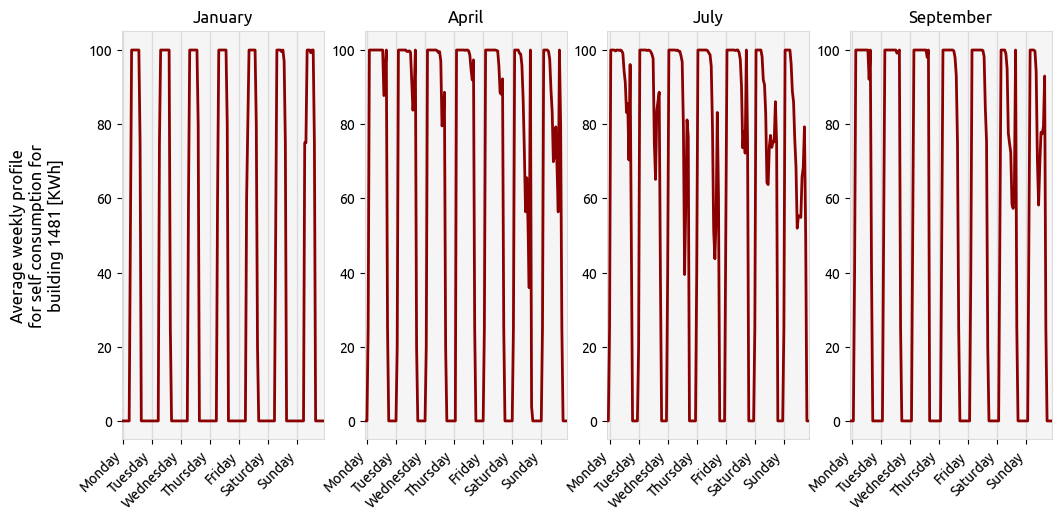

In [20]:
"""
Comparing average weekly profile of self-consumption for different months
"""

import numpy as np

plt.rc('font',family='Ubuntu')
plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"white" , "grid.linestyle":"dashed"})


fig, ax = plt.subplots(1,4,figsize=(12,6))

for k, to_plot in enumerate(['1481_self_consumption']) :


 for m, month in enumerate([0,3,6,8]):   
    ax[m].grid(axis='y')

    string=str(k+1)+' production' 
    column_=[i for i in data_production.columns if string in i][0]
    ## filter out the time period when the solar installation was disconnected   
    to_drop= [i for i in data_production.index if not np.isnan(i.day) and find_empty.loc[ 
    (i.year, i.month, i.day) , column_] ==0
    ]

    data_meter_nozero= meter_data.drop(labels=to_drop)

    df_demand = pd.DataFrame(data_meter_nozero.filter(like=to_plot).groupby(pd.Grouper(freq='1H')).mean()).fillna(0)*100 ##hourly demand KWh
    df_demand = df_demand.loc[[i for i in df_demand.index if i.month==(month+1)]]

    df_demand['weekday']=(df_demand.index.weekday)
    df_demand['hour']=(df_demand.index.hour)
    monday = df_demand[df_demand['weekday']==0].index[0]   
    index =df_demand[monday:monday+timedelta(hours=167)].index ##datetime strarting from a monday at midnight

    df_demand= df_demand.drop(labels=[i for i in df_demand.index if df_demand.loc[i, to_plot]<0])     
    
    ax[m].plot(index, df_demand.groupby([df_demand['weekday'],  
                              df_demand['hour']]).mean().values ,
                          color='darkred',label='Self-consumption',lw=2,zorder =3)

    ax[m].xaxis.set_major_locator(mdates.DayLocator())
    #ax[m].xaxis.set_minor_locator(mdates.HourLocator(byhour = [12]))
    #ax[m].xaxis.set_minor_locator(mdates.HourLocator(byhour = [12]))
    ax[m].xaxis.set_major_formatter(mdates.DateFormatter('%A'))
    #ax[m].xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
    ax[m].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
    ax[m].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
    ax[m].set_xlim([index[0],index[-1]])  

ax[0].set_ylabel('Average weekly profile\nfor self consumption for\nbuilding 1481 [KWh]\n', fontsize=12)
#ax[0].set_ylim([0,100])
ax[0].set_title('January', fontsize=12)
ax[1].set_title('April', fontsize=12)
ax[2].set_title('July', fontsize=12)
ax[3].set_title('September', fontsize=12)

#ax[0].legend()
fig.autofmt_xdate(rotation=45)



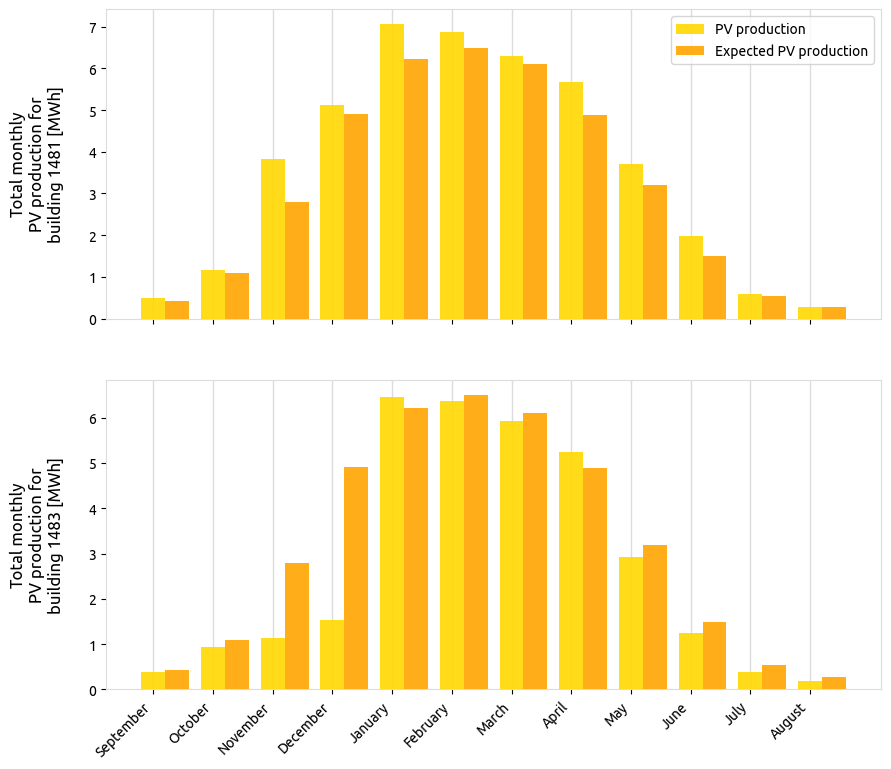

In [21]:
"""
Comparing actual vs. predicted solar PV production

Solar PV production can be predicted for any location using the online open-access tool PVGIS
Visit PVGIS: https://re.jrc.ec.europa.eu/pvg_tools/en/
The data is downloaded for a 10-year period (2013-2023) and averaged (https://github.com/martavp/UEF/upload/main/data/PVGIS).
Note that the the solar installation comprises east-west facing panels with 10 deg. slope. Data from PVGIS is 
calculated for a 1 KW installation and has the unit watts
"""
plt.rc('axes',edgecolor='gainsboro')

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({"axes.grid" : True, "grid.color" :"gainsboro" , "grid.linestyle":"dashed"})

predicted_east =pd.read_csv('Timeseries_56.173_10.206_SA3_1kWp_crystSi_14_10deg_-90deg_2013_2023.csv', index_col= 0, skiprows=10)
predicted_east=predicted_east.drop(labels=[i for i in predicted_east[-7:].index])
predicted_east.index= pd.to_datetime(predicted_east.index ,format='%Y%m%d:%H%M')
predicted_east['P']= pd.to_numeric(predicted_east['P'])

east_generation =pd.DataFrame(predicted_east.groupby([
    predicted_east.index.month,predicted_east.index.day,predicted_east.index.hour]).mean()['P'].values,
    index= predicted_east[8760*3:8760*3+8784].index)

predicted_west =pd.read_csv('Timeseries_56.173_10.206_SA3_1kWp_crystSi_14_10deg_90deg_2013_2023.csv', index_col= 0, skiprows=10)
predicted_west=predicted_west.drop(labels=[i for i in predicted_west[-7:].index])
predicted_west.index= pd.to_datetime(predicted_west.index ,format='%Y%m%d:%H%M')
predicted_west['P']= pd.to_numeric(predicted_west['P'])

west_generation =pd.DataFrame(predicted_west.groupby([
    predicted_west.index.month,predicted_west.index.day,predicted_west.index.hour]).mean()['P'].values,
    index= predicted_west[8760*3:8760*3+8784].index)


total_gen = (east_generation+west_generation)/2


fig, ax = plt.subplots(2,1, figsize=(10,10))

index_1=np.arange(4) 
index_2=np.arange(4,7) 

for k, to_plot in enumerate(['1481_demand','1483_demand']) :
 ax[k].grid(axis='y')

 string=str(k+1)+' production' 
 column_=[i for i in data_production.columns if string in i][0]
 ##Data from PVGIS is for a 1 KW installation, so we multiply by the size of the solar plant in each building (49 KW) and
 ## divide by 1e6 to get MWh   
 expected_production = total_gen.groupby([total_gen.index.month]).sum()*49/1e6  

 to_plot_ = data_production.groupby([data_production.index.month,   
                             ]).sum()[column_]
    
 ax[k].bar(np.arange(len(to_plot_)), to_plot_.values/1e3,  ##september to december MWh  
                          0.4 ,  color='gold',label='PV production',alpha=0.9,lw=2,zorder =3)

 ax[k].bar(np.arange(len(to_plot_))+0.4, expected_production[0].values, 0.4 ,  
                          color='orange',label='Expected PV production',alpha=0.9,lw=2,zorder =3)
 if k==0: ax[k].legend()


 ticklabels = pd.date_range(start=clean_data.index[0], 
                           end=data_production.index[-1], 
                           freq="MS").strftime("%B %Y").tolist()
    
 ax[k].set_xticks(np.arange(len(to_plot_.index)))    
 ax[k].set_xticklabels(["September", 'October', 'November','December',
                       'January','February','March','April','May','June','July','August'])
 ax[k].grid(which = "major", axis = "x", linestyle = "-", linewidth = 1, color='gainsboro')
 ax[k].grid(which = "minor", axis = "x", linestyle = "--", linewidth = 1, color='white')
 #ax[k].set_xlim([index[0],index[-1]])  

ax[0].set_ylabel('Total monthly\nPV production for\nbuilding 1481 [MWh]\n', fontsize=12)
ax[1].set_ylabel('Total monthly\nPV production for\nbuilding 1483 [MWh]\n', fontsize=12)
#ax[0].set_ylim([0,180])
#ax[1].set_ylim([0,100])


fig.autofmt_xdate(rotation=45)

